## AB testing access time for ICESat-2 ATL03 HDF5 files in the cloud.

This notebook requires that we have 2 versions of the same file:
  * Original A: The original file with no modifications on a S3 location.
  * Test Case B: A modified version of the orignal file to test for metadata consolidation, rechunking and other strategies to speed up access to the data in the file.


In [1]:
import xarray as xr
import h5py
import fsspec
import logging
import re
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from h5coro import h5coro, s3driver, filedriver
driver =  s3driver.S3Driver

logger = logging.getLogger('fsspec')
logger.setLevel(logging.DEBUG)

In [2]:
for library in (xr, h5py, fsspec, h5coro):
    print(f'{library.__name__} v{library.__version__}')

xarray v2023.12.0
h5py v3.9.0
fsspec v2023.6.0
h5coro v0.0.6


For listing files in CryoCloud

```bash
aws s3 ls s3://nasa-cryo-persistent/h5cloud/ --recursive
```

In [3]:
test_dict = {
    "ATL03-1GB": {
        "links": {
            "original": "s3://nasa-cryo-persistent/h5cloud/atl03/average/original/ATL03_20230618223036_13681901_006_01.h5",
            "optimized": "s3://nasa-cryo-persistent/h5cloud/atl03/average/repacked/ATL03_20230618223036_13681901_006_01.h5"
        },
        "group": "/gt1l/heights",
        "variable": "h_ph",
        "processing": [
            "h5repack -S PAGE -G 8000000"
        ]
    },
    "ATL03-7GB": {
        "links": {
            "original": "s3://nasa-cryo-persistent/h5cloud/atl03/big/original/ATL03_20181120182818_08110112_006_02.h5",
            "optimized": "s3://nasa-cryo-persistent/h5cloud/atl03/big/repacked/ATL03_20181120182818_08110112_006_02_repacked.h5",
        },
        "group": "/gt1l/heights",
        "variable": "h_ph",
        "processing": [
            "h5repack -S PAGE -G 8000000"
        ]
    },
    "ATL03-7GB-kerchunk": {
        "links": {
            "original": "s3://nasa-cryo-persistent/h5cloud/atl03/big/original/kerchunk/atl03_ATL03_20181120182818_08110112_006_02.json",
            "optimized": "s3://nasa-cryo-persistent/h5cloud/atl03/big/repacked/kerchunk/atl03_ATL03_20181120182818_08110112_006_02_repacked.json",
        },
        "group": "/gt1l/heights",
        "variable": "h_ph",
        "processing": [
            "h5repack -S PAGE -G 8000000"
        ]
    },    
    "ATL03-2GB": {
        "links": {
            "original": "s3://nasa-cryo-persistent/h5cloud/atl03/big/original/ATL03_20210402143840_01341107_006_02.h5",
            "optimized": "s3://nasa-cryo-persistent/h5cloud/atl03/big/repacked/ATL03_20210402143840_01341107_006_02_repacked.h5",
        },
        "group": "/gt1l/heights",
        "variable": "h_ph",
        "processing": [
            "h5repack -S PAGE -G 8000000"
        ]
    }
}

def kerchunk_result(file: str, dataset: str, variable: str):
    fs = fsspec.filesystem(
        "reference",
        fo=file,
        remote_protocol="s3",
        remote_options=dict(anon=False),
        skip_instance_cache=True,
    )
    ds = xr.open_dataset(
        fs.get_mapper(""), engine="zarr", consolidated=False, group=dataset
    )
    return ds[variable].mean()

# This will use the embedded credentials in the hub to access the s3://nasa-cryo-persistent bucket
fs = fsspec.filesystem('s3')


## [h5coro](https://github.com/ICESat2-SlideRule/h5coro/)

**h5coro** is optimized for reading HDF5 data in high-latency high-throughput environments.  It accomplishes this through a few key design decisions:
* __All reads are concurrent.__  Each dataset and/or attribute read by **h5coro** is performed in its own thread.
* __Intelligent range gets__ are used to read as many dataset chunks as possible in each read operation.  This drastically reduces the number of HTTP requests to S3 and means there is no longer a need to re-chunk the data (it actually works better on smaller chunk sizes due to the granularity of the request).
* __Block caching__ is used to minimize the number of GET requests made to S3.  S3 has a large first-byte latency (we've measured it at ~60ms on our systems), which means there is a large penalty for each read operation performed.  **h5coro** performs all reads to S3 as large block reads and then maintains data in a local cache for access to smaller amounts of data within those blocks.
* __The system is serverless__ and does not depend on any external services to read the data. This means it scales naturally as the user application scales, and it reduces overall system complexity.
* __No metadata repository is needed.__  The structure of the file are cached as they are read so that successive reads to other datasets in the same file will not have to re-read and re-build the directory structure of the file.


Processing: s3://nasa-cryo-persistent/h5cloud/atl03/average/original/ATL03_20230618223036_13681901_006_01.h5
Processing: s3://nasa-cryo-persistent/h5cloud/atl03/average/repacked/ATL03_20230618223036_13681901_006_01.h5
Processing: s3://nasa-cryo-persistent/h5cloud/atl03/big/original/ATL03_20181120182818_08110112_006_02.h5
Processing: s3://nasa-cryo-persistent/h5cloud/atl03/big/repacked/ATL03_20181120182818_08110112_006_02_repacked.h5
Processing: s3://nasa-cryo-persistent/h5cloud/atl03/big/original/kerchunk/atl03_ATL03_20181120182818_08110112_006_02.json
Processing: s3://nasa-cryo-persistent/h5cloud/atl03/big/repacked/kerchunk/atl03_ATL03_20181120182818_08110112_006_02_repacked.json
Processing: s3://nasa-cryo-persistent/h5cloud/atl03/big/original/ATL03_20210402143840_01341107_006_02.h5
Processing: s3://nasa-cryo-persistent/h5cloud/atl03/big/repacked/ATL03_20210402143840_01341107_006_02_repacked.h5


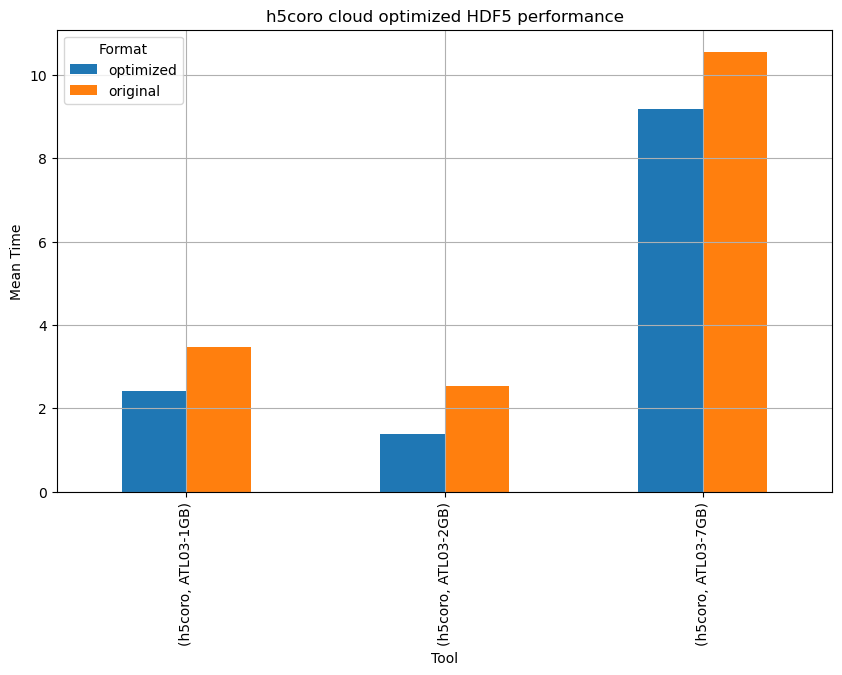

In [33]:
h5coro_beanchmarks = []

for key, dataset in test_dict.items():
    for k, link in dataset["links"].items():
        print (f"Processing: {link}")
        if "kerchunk" in link:
            continue
        group = dataset["group"]
        variable = dataset['variable']     
        final_h5coro_array = []
        start = time.time()
        if link.startswith("s3://nasa-cryo-persistent/"):
            h5obj = h5coro.H5Coro(link.replace("s3://", ""), s3driver.S3Driver)
        else:
            h5obj = h5coro.H5Coro(link.replace("s3://", ""), s3driver.S3Driver, credentials={"annon": True})
        ds = h5obj.readDatasets(datasets=[f'{group}/{variable}'], block=True)
        data = ds[f'{group}/{variable}'][:]
        data_mean = np.mean(data)
        elapsed = time.time() - start
        
        h5coro_beanchmarks.append({"tool": "h5coro",
                                   "dataset": key,
                                   "cloud-aware": "no",
                                   "format": k,
                                   "file": link,
                                   "time": elapsed,
                                   "mean": data_mean})


df = pd.DataFrame.from_dict(h5coro_beanchmarks)

pivot_df = df.pivot_table(index=['tool','dataset'], columns=['format'], values='time', aggfunc='mean')

# Plotting
pivot_df.plot(kind='bar', figsize=(10, 6))
plt.title('h5coro cloud optimized HDF5 performance')
plt.xlabel('Tool')
plt.ylabel('Mean Time')
plt.xticks(rotation=90)
plt.legend(title='Format')
plt.grid(True)
plt.show()

### Xarray + kerchunk, out of the box performance.

In [22]:
# this is going to keep our numbers without modifying the i/o paramters
regular_xarray_benchmarks = []
kerchunk_benchmarks = []

for key, dataset in test_dict.items():
    for k, link in dataset["links"].items():
        print (f"Processing: {link}")
        try:
            log_filename = f"logs/fsspec-xarray-{key}-{k}-default.log"
            
            # Create a new FileHandler for each iteration
            file_handler = logging.FileHandler(log_filename)
            file_handler.setLevel(logging.DEBUG)

            # Add the handler to the root logger
            logging.getLogger().addHandler(file_handler)
 
            start = time.time()
            if "kerchunk" in link:
                data_mean = kerchunk_result(link, dataset["group"], dataset["variable"])
                elapsed = time.time() - start
                kerchunk_benchmarks.append(
                    {"tool": "kerchunk",
                     "dataset": key,
                     "cloud-aware": "no",
                     "format": k,
                     "file": link,
                     "time": elapsed,
                     "mean": data_mean})                
            else:
                ds = xr.open_dataset(fs.open(link, mode='rb'), group=dataset["group"], engine="h5netcdf", decode_cf=False)
                data_mean = ds[dataset["variable"]].mean()    
                elapsed = time.time() - start
                regular_xarray_benchmarks.append(
                    {"tool": "xarray",
                     "dataset": key,
                     "cloud-aware": "no",
                     "format": k,
                     "file": link,
                     "time": elapsed,
                     "mean": data_mean})    
            
            logging.getLogger().removeHandler(file_handler)
            file_handler.close()

        except Exception as e:
            print(e)

Processing: s3://nasa-cryo-persistent/h5cloud/atl03/average/original/ATL03_20230618223036_13681901_006_01.h5
Processing: s3://nasa-cryo-persistent/h5cloud/atl03/average/repacked/ATL03_20230618223036_13681901_006_01.h5
Processing: s3://nasa-cryo-persistent/h5cloud/atl03/big/original/ATL03_20181120182818_08110112_006_02.h5
Processing: s3://nasa-cryo-persistent/h5cloud/atl03/big/repacked/ATL03_20181120182818_08110112_006_02_repacked.h5
Processing: s3://nasa-cryo-persistent/h5cloud/atl03/big/original/kerchunk/atl03_ATL03_20181120182818_08110112_006_02.json
Processing: s3://nasa-cryo-persistent/h5cloud/atl03/big/repacked/kerchunk/atl03_ATL03_20181120182818_08110112_006_02_repacked.json
Processing: s3://nasa-cryo-persistent/h5cloud/atl03/big/original/ATL03_20210402143840_01341107_006_02.h5
Processing: s3://nasa-cryo-persistent/h5cloud/atl03/big/repacked/ATL03_20210402143840_01341107_006_02_repacked.h5


### Plotting Results

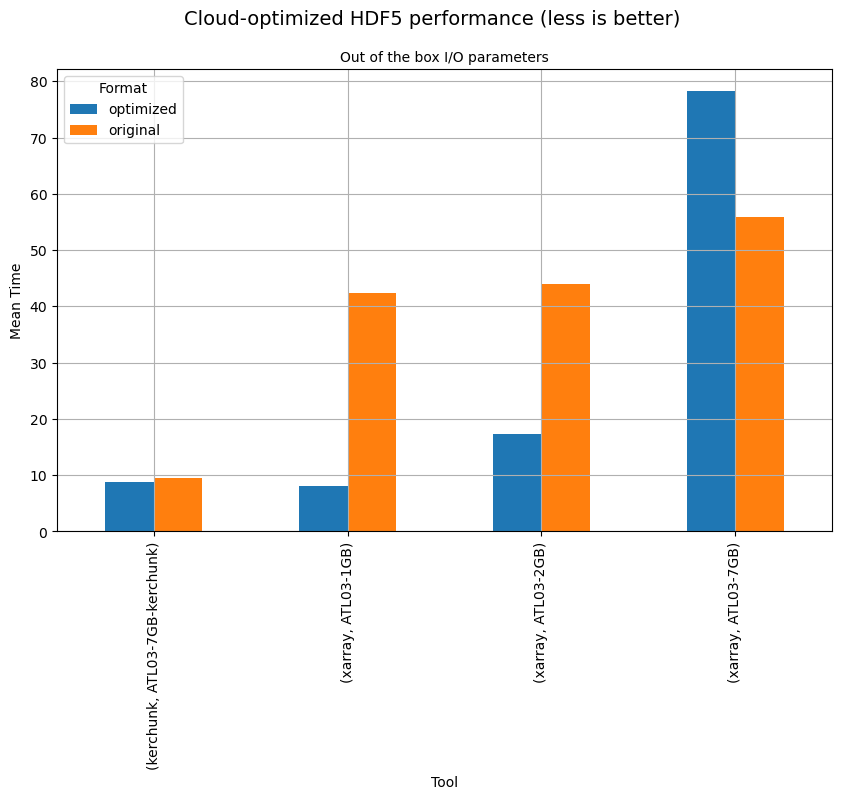

In [24]:
df = pd.DataFrame.from_dict(kerchunk_benchmarks + regular_xarray_benchmarks)

pivot_df = df.pivot_table(index=['tool','dataset'], columns=['format'], values='time', aggfunc='mean')

# Plotting
pivot_df.plot(kind='bar', figsize=(10, 6))

plt.title("Out of the box I/O parameters", fontsize=10)
plt.suptitle('Cloud-optimized HDF5 performance (less is better)', fontsize=14)

plt.xlabel('Tool')
plt.ylabel('Mean Time')
plt.xticks(rotation=90)
plt.legend(title='Format')
plt.grid(True)
plt.show()

## h5py out of the box performance.

In [25]:
regular_h5py_benchmarks = []

for key, dataset in test_dict.items():
    for k, link in dataset["links"].items():
        try:
            if "kerchunk" in link:
                continue   
            print (f"Processing: {link}")
            log_filename = f"logs/fsspec-h5py-{key}-{k}_default.log"
            
            # Create a new FileHandler for each iteration
            file_handler = logging.FileHandler(log_filename)
            file_handler.setLevel(logging.DEBUG)

            # Add the handler to the root logger
            logging.getLogger().addHandler(file_handler)
            # this is mostly IO so no perf_counter is needed
            start = time.time()
            with h5py.File(fs.open(link, mode="rb")) as f:
                path = f"{dataset['group']}/{dataset['variable']}"
                data = f[path][:]
                data_mean = data.mean()
                elapsed = time.time() - start
                regular_h5py_benchmarks.append(
                    {"tool": "h5py",
                     "dataset": key,
                     "cloud-aware": "no",
                     "format": k,
                     "file": link,
                     "time": elapsed,
                     "mean": data_mean})

                logging.getLogger().removeHandler(file_handler)      
                file_handler.close()
            
        except Exception as e:
            print(e)

Processing: s3://nasa-cryo-persistent/h5cloud/atl03/average/original/ATL03_20230618223036_13681901_006_01.h5
Processing: s3://nasa-cryo-persistent/h5cloud/atl03/average/repacked/ATL03_20230618223036_13681901_006_01.h5
Processing: s3://nasa-cryo-persistent/h5cloud/atl03/big/original/ATL03_20181120182818_08110112_006_02.h5
Processing: s3://nasa-cryo-persistent/h5cloud/atl03/big/repacked/ATL03_20181120182818_08110112_006_02_repacked.h5
Processing: s3://nasa-cryo-persistent/h5cloud/atl03/big/original/ATL03_20210402143840_01341107_006_02.h5
Processing: s3://nasa-cryo-persistent/h5cloud/atl03/big/repacked/ATL03_20210402143840_01341107_006_02_repacked.h5


### Plotting Results

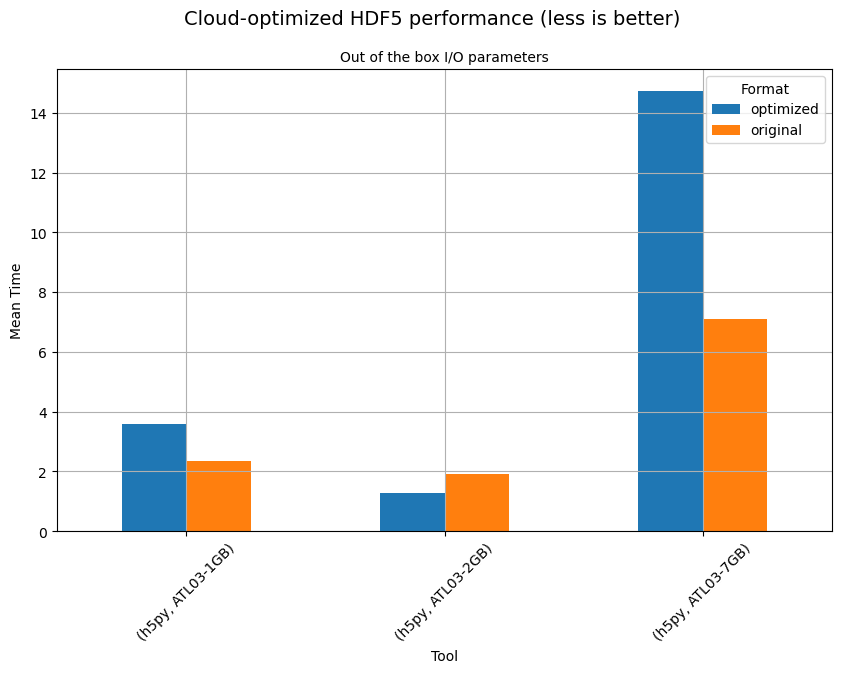

In [26]:
df = pd.DataFrame.from_dict(regular_h5py_benchmarks)

pivot_df = df.pivot_table(index=['tool','dataset'], columns=['format'], values='time', aggfunc='mean')

# Plotting
pivot_df.plot(kind='bar', figsize=(10, 6))
plt.suptitle('Cloud-optimized HDF5 performance (less is better)', fontsize=14)
plt.title("Out of the box I/O parameters", fontsize=10)

plt.xlabel('Tool')
plt.ylabel('Mean Time')
plt.xticks(rotation=45)
plt.legend(title='Format')
plt.grid(True)
plt.show()

## Aggregated plot by tool and different file sizes

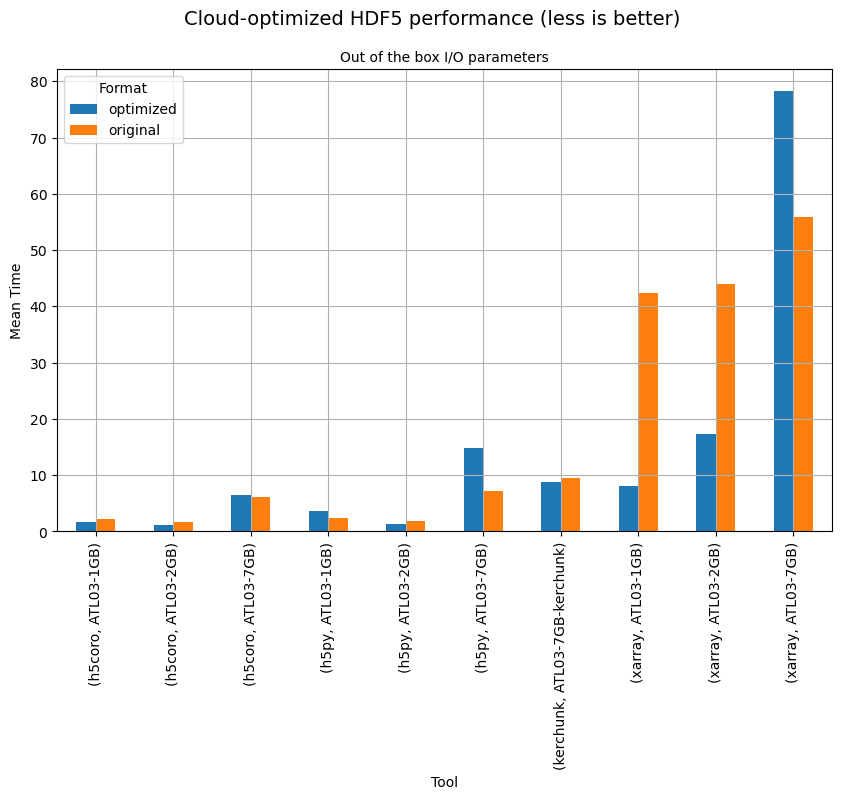

In [27]:
df = pd.DataFrame.from_dict(regular_h5py_benchmarks + kerchunk_benchmarks + regular_xarray_benchmarks + h5coro_beanchmarks)

pivot_df = df.pivot_table(index=['tool','dataset'], columns=['format'], values='time', aggfunc='mean')

# Plotting
pivot_df.plot(kind='bar', figsize=(10, 6))
plt.suptitle('Cloud-optimized HDF5 performance (less is better)', fontsize=14)
plt.title("Out of the box I/O parameters", fontsize=10)
plt.xlabel('Tool')
plt.ylabel('Mean Time')
plt.xticks(rotation=90)
plt.legend(title='Format')
plt.grid(True)
plt.show()

## Now leet's run the tests with "informed" parameters, this is a I/O that aligns to the cloud-optimized granules chunking strategy and consolidated metadata.


In [28]:
optimized_h5py_benchmarks = []
optimized_xarray_benchmarks = []

for key, dataset in test_dict.items():
    for k, link in dataset["links"].items():
        print(f"Processing: {link}")
        try:
            log_filename = f"logs/fsspec-xarray-{key}-{k}.log"
            
            # Create a new FileHandler for each iteration
            file_handler = logging.FileHandler(log_filename)
            file_handler.setLevel(logging.DEBUG)

            # Add the handler to the root logger
            logging.getLogger().addHandler(file_handler)
            
            io_params = {
                "fsspec_params": {},
                "h5py_params": {}
            }
            
            if "repacked" in link:   
                io_params ={
                    "fsspec_params": {
                        "cache_type": "blockcache",
                        "block_size": 8*1024*1024
                    },
                    "h5py_params" : {
                        "driver_kwds": {
                            "page_buf_size": 64*1024*1024,
                            "rdcc_nbytes": 8*1024*1024
                        }

                    }
                }

            if "kerchunk" in link:
                continue
               
            start = time.time()
            ds = xr.open_dataset(fs.open(link, mode='rb', **io_params["fsspec_params"]), group=dataset["group"], engine="h5netcdf", decode_cf=False)
            data_mean = ds[dataset["variable"]].mean()
            elapsed = time.time() - start
            optimized_xarray_benchmarks.append(
                {"tool": "xarray",
                 "dataset": key,
                 "cloud-aware": "yes",
                 "format": k,
                 "file": link,
                 "time": elapsed,
                 "mean": data_mean})
            
            logging.getLogger().removeHandler(file_handler)
            file_handler.close()

        except Exception as e:
            print(e)
            
for key, dataset in test_dict.items():
    for k, link in dataset["links"].items():
        try:
            if "kerchunk" in link:
                continue   
            print (f"Processing: {link}")
            log_filename = f"logs/fsspec-h5py-{key}-{k}_default.log"
            
            # Create a new FileHandler for each iteration
            file_handler = logging.FileHandler(log_filename)
            file_handler.setLevel(logging.DEBUG)

            # Add the handler to the root logger
            logging.getLogger().addHandler(file_handler)
            # this is mostly IO so no perf_counter is needed
            start = time.time()
            io_params = {
                "fsspec_params": {},
                "h5py_params": {}
            }
            
            if "repacked" in link:   
                io_params ={
                    "fsspec_params": {
                        "cache_type": "blockcache",
                        "block_size": 8*1024*1024
                    },
                    "h5py_params" : {
                        "page_buf_size": 64*1024*1024,
                        "rdcc_nbytes": 8*1024*1024
                    }
                }            
            with h5py.File(fs.open(link, mode="rb", **io_params["fsspec_params"]), **io_params["h5py_params"]) as f:
                path = f"{dataset['group']}/{dataset['variable']}"
                data = f[path][:]
                data_mean = data.mean()
                elapsed = time.time() - start
                optimized_h5py_benchmarks.append(
                    {"tool": "h5py",
                     "dataset": key,
                     "cloud-aware": "yes",
                     "format": k,
                     "file": link,
                     "time": elapsed,
                     "mean": data_mean})

                logging.getLogger().removeHandler(file_handler)      
                file_handler.close()
            

        except Exception as e:
            print(e)

Processing: s3://nasa-cryo-persistent/h5cloud/atl03/average/original/ATL03_20230618223036_13681901_006_01.h5
Processing: s3://nasa-cryo-persistent/h5cloud/atl03/average/repacked/ATL03_20230618223036_13681901_006_01.h5
Processing: s3://nasa-cryo-persistent/h5cloud/atl03/big/original/ATL03_20181120182818_08110112_006_02.h5
Processing: s3://nasa-cryo-persistent/h5cloud/atl03/big/repacked/ATL03_20181120182818_08110112_006_02_repacked.h5
Processing: s3://nasa-cryo-persistent/h5cloud/atl03/big/original/kerchunk/atl03_ATL03_20181120182818_08110112_006_02.json
Processing: s3://nasa-cryo-persistent/h5cloud/atl03/big/repacked/kerchunk/atl03_ATL03_20181120182818_08110112_006_02_repacked.json
Processing: s3://nasa-cryo-persistent/h5cloud/atl03/big/original/ATL03_20210402143840_01341107_006_02.h5
Processing: s3://nasa-cryo-persistent/h5cloud/atl03/big/repacked/ATL03_20210402143840_01341107_006_02_repacked.h5
Processing: s3://nasa-cryo-persistent/h5cloud/atl03/average/original/ATL03_20230618223036_1

## Plotting results

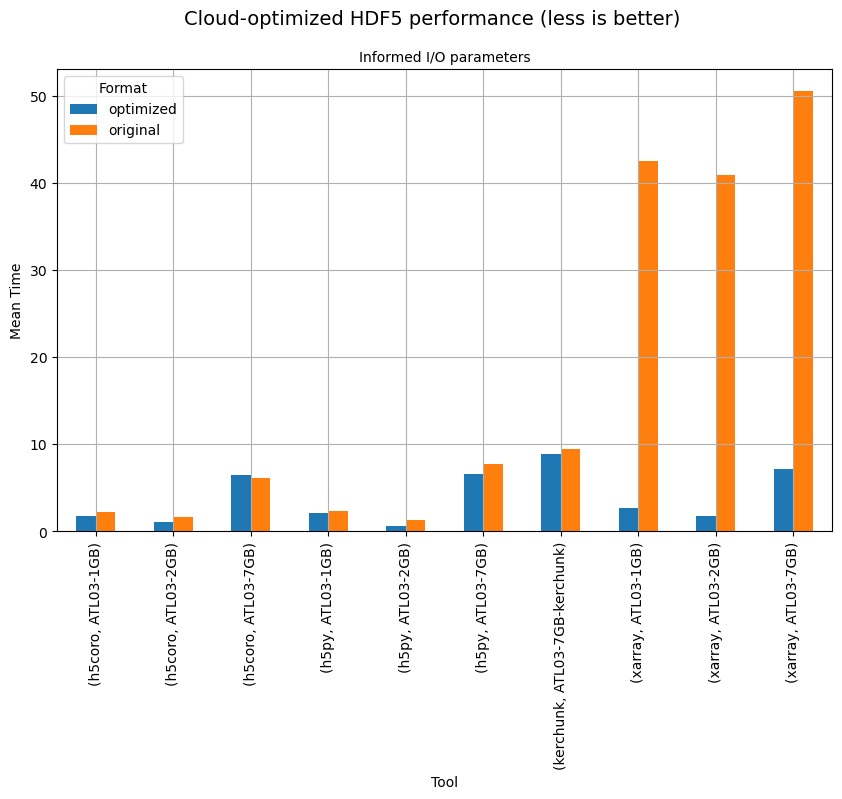

In [29]:
df = pd.DataFrame.from_dict(optimized_h5py_benchmarks+h5coro_beanchmarks+optimized_xarray_benchmarks+kerchunk_benchmarks)

pivot_df = df.pivot_table(index=['tool','dataset'], columns=['format'], values='time', aggfunc='mean')

# Plotting
pivot_df.plot(kind='bar', figsize=(10, 6))

plt.suptitle('Cloud-optimized HDF5 performance (less is better)', fontsize=14)
plt.title("Informed I/O parameters", fontsize=10)
plt.xlabel('Tool')
plt.ylabel('Mean Time')
plt.xticks(rotation=90)
plt.legend(title='Format')
plt.grid(True)
plt.show()

## Pliting tool specific performance

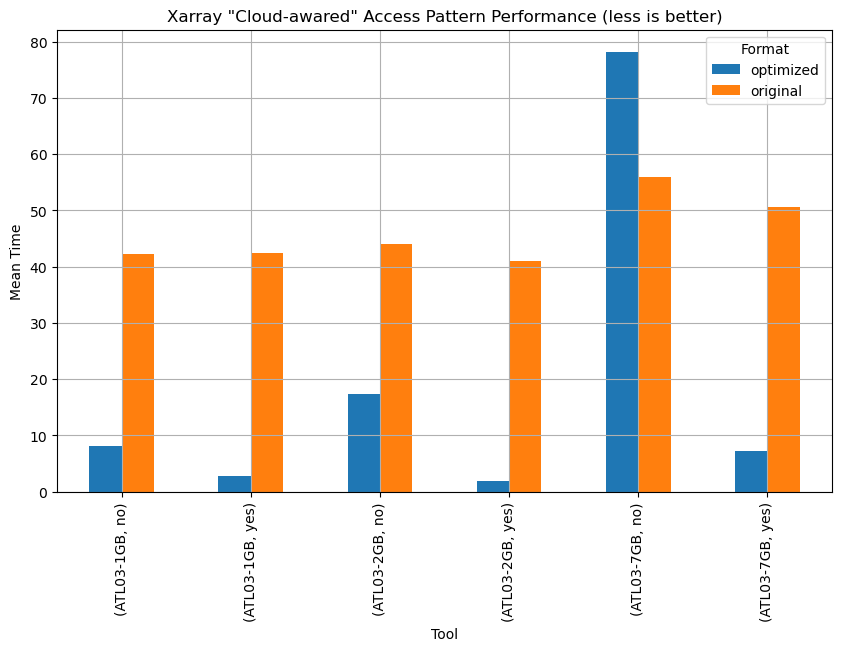

In [32]:
df = pd.DataFrame.from_dict(regular_xarray_benchmarks+optimized_xarray_benchmarks)

pivot_df = df.pivot_table(index=['dataset','cloud-aware'], columns=['format'], values='time', aggfunc='mean')

# Plotting
pivot_df.plot(kind='bar', figsize=(10, 6))
plt.title('Xarray "Cloud-awared" Access Pattern Performance (less is better)')
plt.xlabel('Tool')
plt.ylabel('Mean Time')
plt.xticks(rotation=90)
plt.legend(title='Format')
plt.grid(True)
plt.show()